In [199]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans

%matplotlib inline

RFM Analysis
============
In this ipynb file, We aim to create columns below
- customer_unique_id: unique key
- recency: days since last purchase
- frequency: number of purchases
- monetary: total amount of purchases
- recency_cluster
- frequency_cluster
- monetary_cluster
- overall_score: sum or product of recency_cluster, frequency_cluster, monetary_cluster

Used clustering algorithm
- KMeans

In [200]:
## Use 3 datasets
df_customers = pd.read_csv('../datasets/olist_customers_dataset.csv')
df_orders = pd.read_csv('../datasets/olist_orders_dataset.csv')
df_order_payments = pd.read_csv('../datasets/olist_order_payments_dataset.csv')

In [201]:
## Merge datasets
df = pd.merge(df_orders, df_customers, on='customer_id') ## Memo: 'customer_id' is foreign key, not unique

order_payments = df_order_payments.groupby('order_id').agg({'payment_value': 'sum'}).reset_index()
df = pd.merge(df, order_payments, on='order_id')
print(f"df_orders: {df_orders.shape}")
print(f"df_customers: {df_customers.shape}")
print(f"df: {df.shape}")

df_orders: (99441, 8)
df_customers: (99441, 5)
df: (99440, 13)


In [202]:
df.describe()

,customer_zip_code_prefix,payment_value
count,99440.000000,99440.000000
mean,35137.681114,160.990267
std,29798.017652,221.951257
min,1003.000000,0.000000
25%,11347.000000,62.010000
50%,24416.000000,105.290000
75%,58900.000000,176.970000
max,99990.000000,13664.080000


In [203]:
print(f"{df[df['payment_value'] == 0].shape[0]} rows are deleted.")
df.drop(df[df['payment_value'] == 0].index, inplace=True)

3 rows are deleted.


In [204]:
## datatypes for each column
df.dtypes

## some data objects should be converted to datetime

order_id                          object
customer_id                       object
order_status                      object
order_purchase_timestamp          object
order_approved_at                 object
order_delivered_carrier_date      object
order_delivered_customer_date     object
order_estimated_delivery_date     object
customer_unique_id                object
customer_zip_code_prefix           int64
customer_city                     object
customer_state                    object
payment_value                    float64
dtype: object

In [205]:
## Convert data object to datetime
columns = [
  'order_purchase_timestamp',
  'order_approved_at',
  'order_delivered_carrier_date',
  'order_delivered_customer_date',
  'order_estimated_delivery_date'
]

for col in columns:
  df[col] = pd.to_datetime(df[col], format='%Y-%m-%d %H:%M:%S')

## Recency

In [206]:
## We use df_rfm for Recency, Frequency, Monetary
df_unique = df.drop_duplicates(subset='customer_unique_id')
df_rfm = pd.DataFrame(df_unique['customer_unique_id'])

## Get the latest purchase date for each customer
df_latest_purchase = df.groupby('customer_unique_id')['order_purchase_timestamp'].max().reset_index()
df_latest_purchase.columns = ['customer_unique_id', 'latest_purchase_date']
## Get Recency
df_latest_purchase['recency'] = (
    df_latest_purchase['latest_purchase_date'].max() - df_latest_purchase['latest_purchase_date']
).dt.days
df_latest_purchase.drop('latest_purchase_date', axis=1, inplace=True)

## Merge Recency to df_rfm
df_rfm = df_rfm.merge(df_latest_purchase, on='customer_unique_id')

df_rfm.head()

,customer_unique_id,recency
0,7c396fd4830fd04220f754e42b4e5bff,380
1,af07308b275d755c9edb36a90c618231,84
2,3a653a41f6f9fc3d2a113cf8398680e8,70
3,7c142cf63193a1473d2e66489a9ae977,332
4,72632f0f9dd73dfee390c9b22eb56dd6,245


/Users/yukiogawa/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/yukiogawa/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/yukiogawa/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/yukiogawa/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` wi

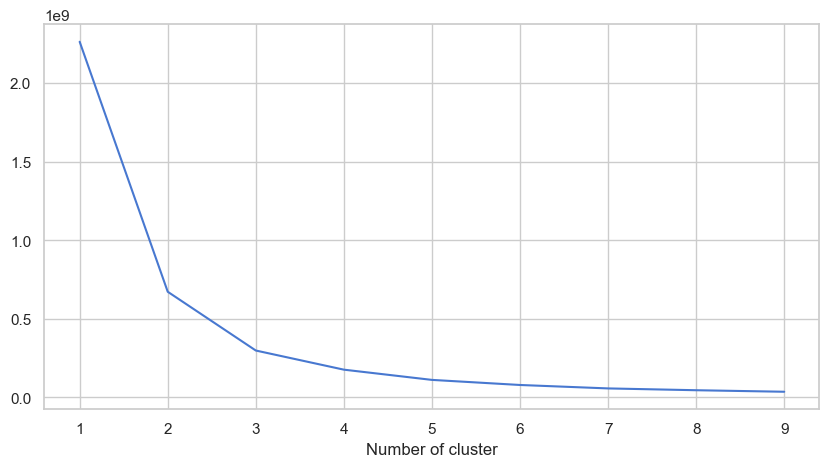

In [207]:
## Use k-means to get recency_cluster
## First of all, we need to know the optimal number of clusters
sse={}
df_recency = df_rfm[['recency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df_recency)
    sse[k] = kmeans.inertia_

plt.figure(figsize=(10, 5))
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [208]:
## The plot shows that the optimal number is 4 or 5. We choose 4
kmeans = KMeans(n_clusters=4)
kmeans.fit(df_rfm[['recency']])
df_rfm['recency_cluster'] = kmeans.predict(df_rfm[['recency']])

# recency_cluster's number is not meaningful, we need to change it to meaningful number
def order_cluster(cluster_column_name, target_column_name, df, ascending=False):
    df_tmp = df.groupby(cluster_column_name)[target_column_name].mean().reset_index()
    df_tmp = df_tmp.sort_values(by=target_column_name, ascending=ascending).reset_index(drop=True)
    df_tmp['index'] = df_tmp.index + 1 ## plus 1 because we don't want to start from 0. We may multiply 3 clusters for overall score

    df_output = pd.merge(
        df,
        df_tmp[[cluster_column_name, 'index']],
        on=cluster_column_name
    )
    df_output = df_output.drop([cluster_column_name], axis=1)
    df_output = df_output.rename(columns = {"index": cluster_column_name})
    return df_output

df_rfm = order_cluster('recency_cluster', 'recency', df_rfm)

df_rfm.groupby('recency_cluster')['recency'].describe()

/Users/yukiogawa/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,count,mean,std,min,25%,50%,75%,max
recency_cluster,,,,,,,,
1,17184.0,533.968401,59.555038,449.0,487.0,525.0,576.0,772.0
2,25203.0,363.172360,43.604088,298.0,325.0,356.0,400.0,448.0
3,27769.0,232.372754,35.122056,172.0,203.0,232.0,263.0,297.0
4,25937.0,110.571847,36.067286,0.0,77.0,110.0,144.0,171.0


In [209]:
## The count and mean values show the recency_cluster is meaningful


## Frequency

In [210]:
df_frequency = df.groupby('customer_unique_id')['order_id'].nunique().reset_index()
df_frequency.columns = ['customer_unique_id', 'frequency']

## Merge Frequency to df_rfm
df_rfm = df_rfm.merge(df_frequency, on='customer_unique_id')

df_rfm['frequency'].describe()

count    96093.000000
mean         1.034800
std          0.214364
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         17.000000
Name: frequency, dtype: float64

In [211]:
## The table above shows that most customers ordered only once.

# count the number that frequency is more than 1
repeater_nu = df_frequency[df_frequency['frequency'] > 1].shape[0]
repeater_ratio = repeater_nu / df_frequency.shape[0]
print('The number of repeater:', repeater_nu)
print('The ratio of repeater:', repeater_ratio)

The number of repeater: 2996
The ratio of repeater: 0.031178129520360483


In [212]:
## Create 2 clusters, ordered more than once(2)? or only once(1)?
df_rfm['frequency_cluster'] = np.where(df_rfm['frequency'] > 1, 2, 1)
df_rfm.groupby('frequency_cluster')['frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
frequency_cluster,,,,,,,,
1,93097.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
2,2996.0,2.116155,0.516692,2.0,2.0,2.0,2.0,17.0


## Monetary

In [213]:
df_monetary = df.groupby('customer_unique_id')['payment_value'].sum().reset_index()
df_monetary.rename(columns={'payment_value': 'monetary'}, inplace=True)

df_rfm = df_rfm.merge(df_monetary, on='customer_unique_id')

df_monetary.describe()

,monetary
count,96093.000000
mean,166.597693
std,231.430072
min,9.590000
25%,63.130000
50%,108.000000
75%,183.530000
max,13664.080000


/Users/yukiogawa/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/yukiogawa/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/yukiogawa/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/yukiogawa/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` wi

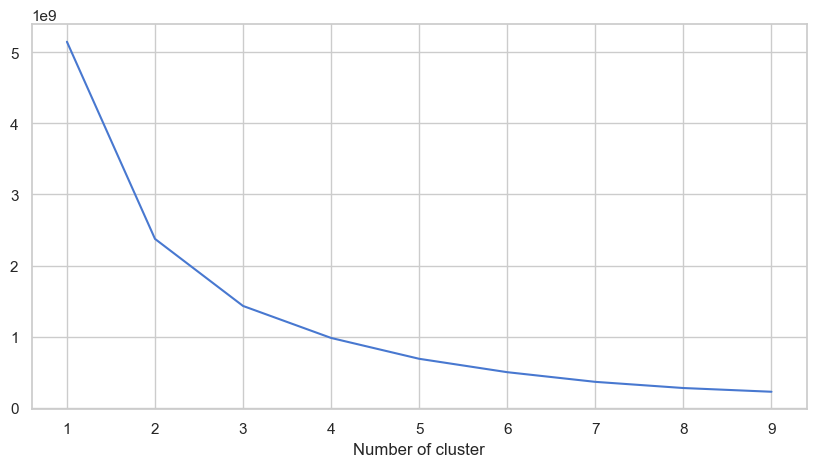

In [214]:
## Use k-means
sse={}
df_revenue = df_rfm[['monetary']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df_revenue)
    sse[k] = kmeans.inertia_

plt.figure(figsize=(10, 5))
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [215]:
## The plot shows that the optimal number is 4, 5, or 6. We choose 5.
kmeans = KMeans(n_clusters=6)
kmeans.fit(df_rfm[['monetary']])
df_rfm['monetary_cluster'] = kmeans.predict(df_rfm[['monetary']])


#order the cluster numbers
df_rfm = order_cluster('monetary_cluster', 'monetary', df_rfm)

#show details of the dataframe
df_rfm.groupby('monetary_cluster')['monetary'].describe()

/Users/yukiogawa/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,count,mean,std,min,25%,50%,75%,max
monetary_cluster,,,,,,,,
1,8.0,8090.416250,2471.190122,6081.54,6873.3225,7102.095,8066.9775,13664.08
2,268.0,2447.696157,624.771947,1859.10,2027.5525,2196.400,2713.3600,4809.44
3,1062.0,1266.297938,240.843519,942.78,1053.7650,1225.590,1426.3175,1853.75
4,4240.0,616.505406,138.218926,433.07,497.5000,594.550,712.3800,941.12
5,22164.0,249.014415,69.237593,167.19,192.6575,227.270,294.0625,432.93
6,68351.0,85.005624,39.376445,9.59,52.1800,78.860,115.9000,167.18


In [216]:
## Most cusotmers in the cluster 6.
## So I use log transformation, and recreate the clusters.

## Remove monetary_cluster column
# df_rfm = df_rfm.drop('monetary_cluster', axis=1)

# Apply log transformation
df_rfm['monetary_log'] = np.log(df_rfm['monetary'])
df_rfm['monetary_log'].describe()


count    96093.000000
mean         4.721357
std          0.819648
min          2.260721
25%          4.145196
50%          4.682131
75%          5.212378
max          9.522526
Name: monetary_log, dtype: float64

In [217]:
# Run K-means on the transformed data
kmeans = KMeans(n_clusters=6)
kmeans.fit(df_rfm[['monetary_log']])
df_rfm['monetary_cluster'] = kmeans.predict(df_rfm[['monetary_log']])

# Order the cluster numbers
df_rfm = order_cluster('monetary_cluster', 'monetary_log', df_rfm, True)

# Show details of the dataframe
df_rfm.groupby('monetary_cluster')['monetary_log'].describe()

/Users/yukiogawa/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,count,mean,std,min,25%,50%,75%,max
monetary_cluster,,,,,,,,
1,13619.0,3.534398,0.231883,2.260721,3.401864,3.579622,3.718924,3.837299
2,21948.0,4.143398,0.158844,3.837730,4.011325,4.158883,4.279302,4.410007
3,24538.0,4.677593,0.153043,4.410128,4.546587,4.680092,4.807866,4.938136
4,21639.0,5.196429,0.161601,4.938208,5.058663,5.178858,5.330639,5.517292
5,10560.0,5.833590,0.216328,5.517533,5.649045,5.800213,5.991583,6.322116
6,3789.0,6.806040,0.416564,6.322260,6.482174,6.696664,7.026054,9.522526


## Overall Score
We can create two types of overall score
1. Sum of recency, frequency, and monetary
2. Product of recency, frequency, and monetary

### 1. Overall Score (sum)

In [218]:
## Now, we have recency_cluster, and monetary_cluster. Let's get the overall RFM Score.
df_rfm['overall_score_sum'] = df_rfm['recency_cluster'] + df_rfm['frequency_cluster'] + df_rfm['monetary_cluster']

In [219]:
df_rfm.groupby('overall_score_sum')[['recency', 'frequency', 'monetary_log']].mean()

,recency,frequency,monetary_log
overall_score_sum,,,
3,537.807903,1.000000,3.537528
4,454.173930,1.000802,3.872280
5,377.772421,1.002783,4.133823
6,307.631522,1.006663,4.390698
7,261.683169,1.016670,4.763121
8,219.288232,1.034038,5.145856
9,178.704231,1.079577,5.533389
10,151.381893,1.181315,6.027602
11,120.264234,1.389051,6.594224


In [220]:
df_rfm.groupby('overall_score_sum')['overall_score_sum'].count()

overall_score_sum
3      2556
4      7480
5     14373
6     19510
7     19916
8     16511
9     10116
10     4153
11     1370
12      108
Name: overall_score_sum, dtype: int64

In [221]:
## Segment customers based on their overall_score_sum
## We can change the threshold values


df_rfm['segment_sum'] = 'Low-Value'
df_rfm.loc[df_rfm['overall_score_sum'] > 7,'segment_sum'] = 'Mid-Value'
df_rfm.loc[df_rfm['overall_score_sum'] > 9,'segment_sum'] = 'High-Value'

df_rfm.head()

,customer_unique_id,recency,recency_cluster,frequency,frequency_cluster,monetary,monetary_log,monetary_cluster,overall_score_sum,segment_sum
0,7c396fd4830fd04220f754e42b4e5bff,380,2,2,2,82.82,4.416670,3,7,Low-Value
1,634f09f6075fe9032e6c19609ffe995a,356,2,1,1,92.97,4.532277,3,6,Low-Value
2,d699688533772c15a061e8ce81cb56df,394,2,1,1,118.86,4.777946,3,6,Low-Value
3,4ca5f90433afb5493247f0bafb583483,439,2,1,1,95.67,4.560905,3,6,Low-Value
4,12e7a2c201751ddc979e7a45cef500f3,433,2,1,1,130.56,4.871833,3,6,Low-Value


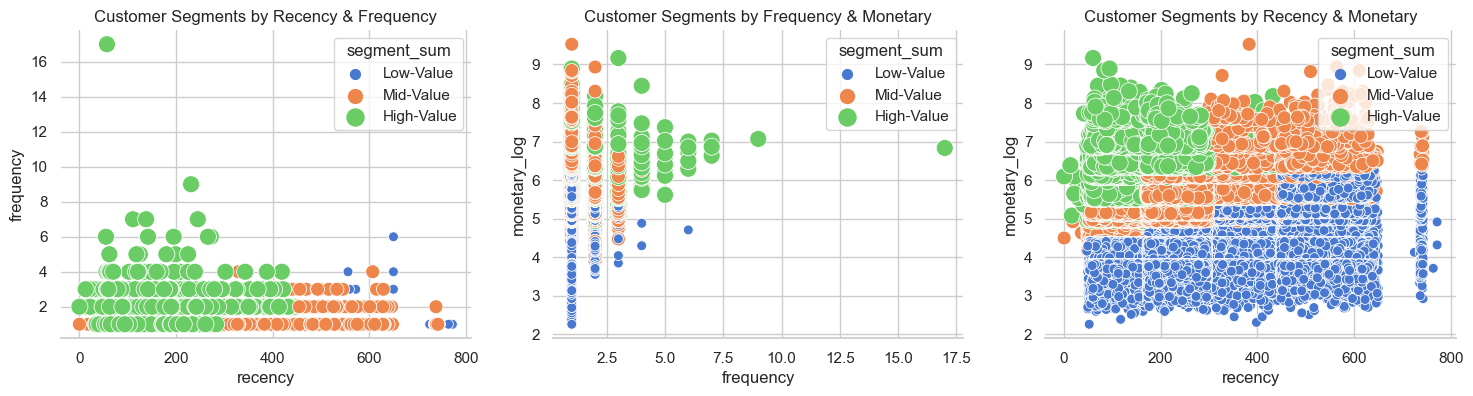

In [222]:
## Visualization: Customer Semgments, using 'egment_sum' column
sns.set_theme(palette='muted', color_codes=True, style='whitegrid')
fig, axs = plt.subplots(1, 3, figsize=(18, 4))
sns.despine(left=True)
sns.scatterplot(x='recency', y='frequency', ax=axs[0], hue='segment_sum', data=df_rfm, size='segment_sum', sizes=(50,150), size_order=['High-Value','Mid-Value','Low-Value'])
sns.scatterplot(x='frequency', y='monetary_log', ax=axs[1], hue='segment_sum', data=df_rfm, size='segment_sum' , sizes=(50,150), size_order=['High-Value','Mid-Value','Low-Value'])
sns.scatterplot(x='recency', y='monetary_log', ax=axs[2], hue='segment_sum', data=df_rfm, size='segment_sum' , sizes=(50,150), size_order=['High-Value','Mid-Value','Low-Value'])
axs[0].set_title('Customer Segments by Recency & Frequency')
axs[1].set_title('Customer Segments by Frequency & Monetary')
axs[2].set_title('Customer Segments by Recency & Monetary')
plt.show()

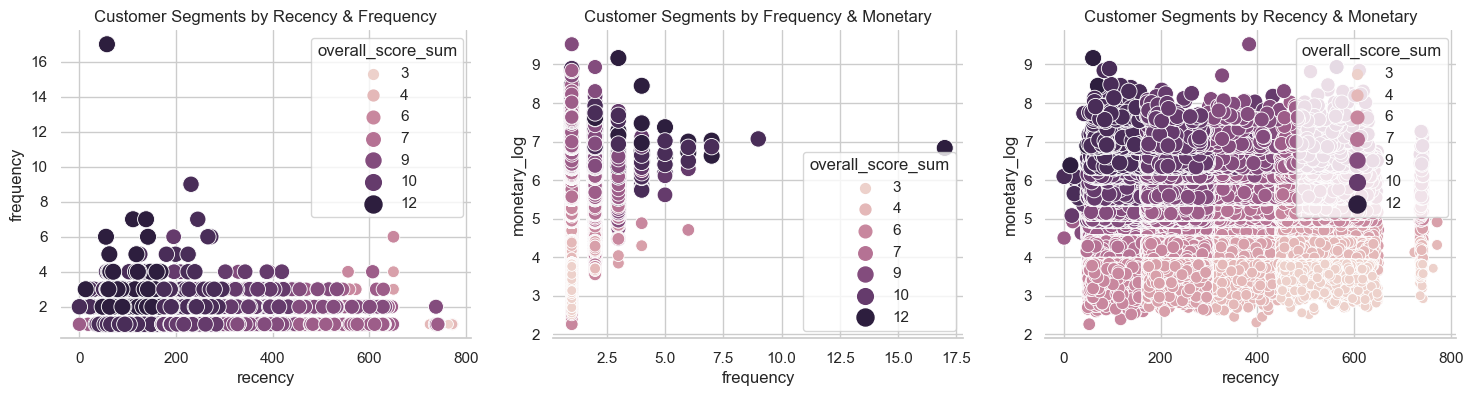

In [223]:
## Visualization: Customer Semgments, using 'overall_score_sum' column
sns.set_theme(palette='muted', color_codes=True, style='whitegrid')
fig, axs = plt.subplots(1, 3, figsize=(18, 4))
sns.despine(left=True)
sns.scatterplot(x='recency', y='frequency', ax=axs[0], hue='overall_score_sum', data=df_rfm, size='overall_score_sum', sizes=(50,150))
sns.scatterplot(x='frequency', y='monetary_log', ax=axs[1], hue='overall_score_sum', data=df_rfm, size='overall_score_sum' , sizes=(50,150))
sns.scatterplot(x='recency', y='monetary_log', ax=axs[2], hue='overall_score_sum', data=df_rfm, size='overall_score_sum' , sizes=(50,150))
axs[0].set_title('Customer Segments by Recency & Frequency')
axs[1].set_title('Customer Segments by Frequency & Monetary')
axs[2].set_title('Customer Segments by Recency & Monetary')
plt.show()

### Overall Score (product)

In [224]:
df_rfm['overall_score_product'] = df_rfm['recency_cluster'] * df_rfm['frequency_cluster'] * df_rfm['monetary_cluster']

df_rfm.groupby('overall_score_product')[['recency', 'frequency', 'monetary_log']].mean()

,recency,frequency,monetary_log
overall_score_product,,,
1,537.807903,1.000000,3.537528
2,454.173930,1.000802,3.872280
3,386.377134,1.000000,4.119778
4,341.697883,1.003046,4.261310
5,539.650513,1.000000,5.830678
6,311.787753,1.007290,4.530674
8,234.971854,1.016419,4.649766
9,232.643764,1.000000,4.675237
10,367.694268,1.046834,5.823329


In [225]:
df_rfm.groupby('overall_score_product')['overall_score_product'].count()

overall_score_product
1      2556
2      7480
3      8318
4     13134
5      1754
6     13032
8     11085
9      6928
10     2669
12    13964
15     2701
16     5991
18     1069
20     2798
24     1477
30      304
32      292
36       99
40      334
48      108
Name: overall_score_product, dtype: int64

In [226]:
## Segment customers based on their overall_score_product
## We can change the threshold values
df_rfm['segment_product'] = 'Low-Value'
df_rfm.loc[df_rfm['overall_score_product'] > 10, 'segment_score'] = 'Mid-Value'
df_rfm.loc[df_rfm['overall_score_product'] > 24,'segment_score'] = 'High-Value'

df_rfm.head()

,customer_unique_id,recency,recency_cluster,frequency,frequency_cluster,monetary,monetary_log,monetary_cluster,overall_score_sum,segment_sum,overall_score_product,segment_product,segment_score
0,7c396fd4830fd04220f754e42b4e5bff,380,2,2,2,82.82,4.416670,3,7,Low-Value,12,Low-Value,Mid-Value
1,634f09f6075fe9032e6c19609ffe995a,356,2,1,1,92.97,4.532277,3,6,Low-Value,6,Low-Value,NaN
2,d699688533772c15a061e8ce81cb56df,394,2,1,1,118.86,4.777946,3,6,Low-Value,6,Low-Value,NaN
3,4ca5f90433afb5493247f0bafb583483,439,2,1,1,95.67,4.560905,3,6,Low-Value,6,Low-Value,NaN
4,12e7a2c201751ddc979e7a45cef500f3,433,2,1,1,130.56,4.871833,3,6,Low-Value,6,Low-Value,NaN


In [227]:
df_rfm = df_rfm[[
    'customer_unique_id',
    'recency',
    'frequency',
    'monetary',
    'monetary_log',
    'recency_cluster',
    'frequency_cluster',
    'monetary_cluster',
    'overall_score_sum',
    'overall_score_product',
    'segment_sum',
    'segment_product',
    'segment_score'
]]

df_rfm.head(10)

,customer_unique_id,recency,frequency,monetary,monetary_log,recency_cluster,frequency_cluster,monetary_cluster,overall_score_sum,overall_score_product,segment_sum,segment_product,segment_score
0,7c396fd4830fd04220f754e42b4e5bff,380,2,82.82,4.416670,2,2,3,7,12,Low-Value,Low-Value,Mid-Value
1,634f09f6075fe9032e6c19609ffe995a,356,1,92.97,4.532277,2,1,3,6,6,Low-Value,Low-Value,NaN
2,d699688533772c15a061e8ce81cb56df,394,1,118.86,4.777946,2,1,3,6,6,Low-Value,Low-Value,NaN
3,4ca5f90433afb5493247f0bafb583483,439,1,95.67,4.560905,2,1,3,6,6,Low-Value,Low-Value,NaN
4,12e7a2c201751ddc979e7a45cef500f3,433,1,130.56,4.871833,2,1,3,6,6,Low-Value,Low-Value,NaN
5,6da92ae920ab16fc4eceb8fcd7bd43ce,320,1,91.66,4.518086,2,1,3,6,6,Low-Value,Low-Value,NaN
6,bb4d84a2b45b22ed710ac8c0dec63d1a,444,2,133.05,4.890725,2,2,3,7,12,Low-Value,Low-Value,Mid-Value
7,7973a6ba9c81ecaeb3d628c33c7c7c48,392,2,115.74,4.751346,2,2,3,7,12,Low-Value,Low-Value,Mid-Value
8,781ae350edb16842380e81d7c7feb431,329,1,101.74,4.622421,2,1,3,6,6,Low-Value,Low-Value,NaN
9,7d185d821a11c769636247766f1fd45e,324,1,135.51,4.909045,2,1,3,6,6,Low-Value,Low-Value,NaN


In [228]:
df_rfm.shape

(96093, 13)

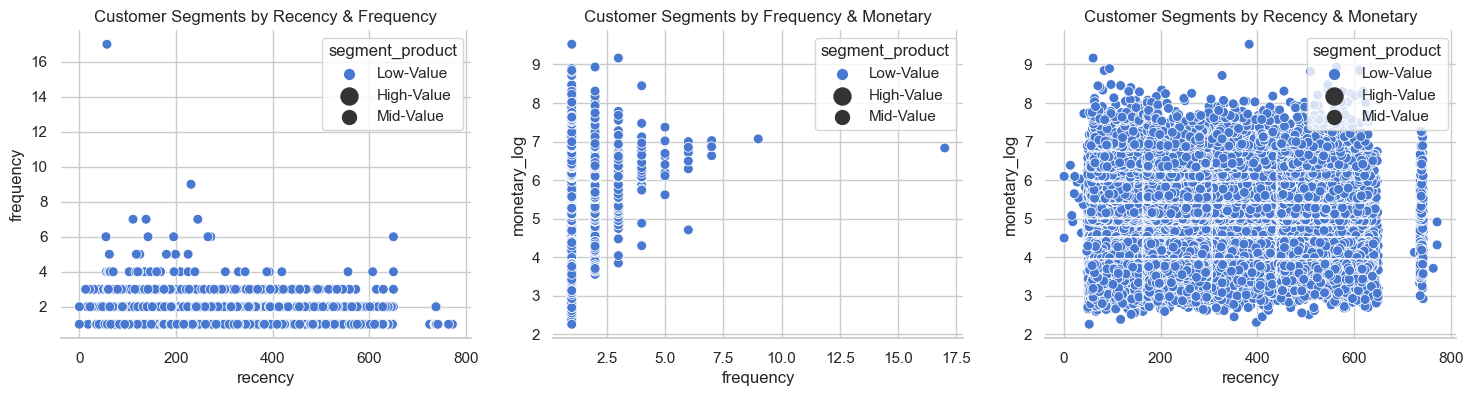

In [229]:
## Visualization: Customer Semgments, using 'segment_product' column
sns.set_theme(palette='muted', color_codes=True, style='whitegrid')
fig, axs = plt.subplots(1, 3, figsize=(18, 4))
sns.despine(left=True)
sns.scatterplot(x='recency', y='frequency', ax=axs[0], hue='segment_product', data=df_rfm, size='segment_product', sizes=(50,150), size_order=['High-Value','Mid-Value','Low-Value'])
sns.scatterplot(x='frequency', y='monetary_log', ax=axs[1], hue='segment_product', data=df_rfm, size='segment_product' , sizes=(50,150), size_order=['High-Value','Mid-Value','Low-Value'])
sns.scatterplot(x='recency', y='monetary_log', ax=axs[2], hue='segment_product', data=df_rfm, size='segment_product' , sizes=(50,150), size_order=['High-Value','Mid-Value','Low-Value'])
axs[0].set_title('Customer Segments by Recency & Frequency')
axs[1].set_title('Customer Segments by Frequency & Monetary')
axs[2].set_title('Customer Segments by Recency & Monetary')
plt.show()

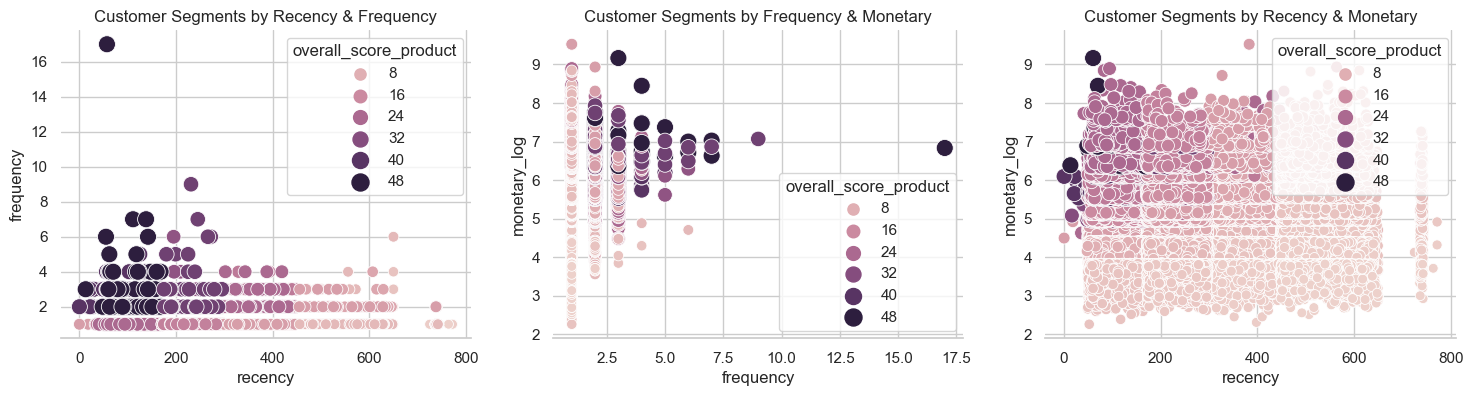

In [230]:
## Visualization: Customer Semgments, using 'overall_score_product' column
sns.set_theme(palette='muted', color_codes=True, style='whitegrid')
fig, axs = plt.subplots(1, 3, figsize=(18, 4))
sns.despine(left=True)
sns.scatterplot(x='recency', y='frequency', ax=axs[0], hue='overall_score_product', data=df_rfm, size='overall_score_product', sizes=(50,150))
sns.scatterplot(x='frequency', y='monetary_log', ax=axs[1], hue='overall_score_product', data=df_rfm, size='overall_score_product' , sizes=(50,150))
sns.scatterplot(x='recency', y='monetary_log', ax=axs[2], hue='overall_score_product', data=df_rfm, size='overall_score_product' , sizes=(50,150))
axs[0].set_title('Customer Segments by Recency & Frequency')
axs[1].set_title('Customer Segments by Frequency & Monetary')
axs[2].set_title('Customer Segments by Recency & Monetary')
plt.show()

### TODO (optional)
We can calculate overall score by weighting each feature differently.
For example, we can give more weight to recency than frequency and monetary.